0. 由于其复杂的依赖环境，必须使用 mamba 库创建虚拟环境

1. 给基础环境安装 mamba 库

```
conda install -n base mamba -c conda-forge -y
```

2. 使用 mamba 创建虚拟环境

```
mamba create -n samgeo segment-geospatial python=3.9 -c conda-forge
```

3. 激活虚拟环境

```
conda activate samgeo
```

4. conda 安装 cuda11.3 支持

```
conda install cudatoolkit=11.3 -c conda-forge -y
```

5. pip 重新安装 pytorch

```
pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 --extra-index-url https://download.pytorch.org/whl/cu113
```

In [1]:
import os
import leafmap
from samgeo import SamGeo, tms_to_geotiff

## 1 数据准备

### 1.1 加载交互式地图

In [3]:
point = [30.532181687, 114.024938132]
Map = leafmap.Map(center=point, zoom=16)
Map.add_basemap("SATELLITE")
Map

Map(center=[30.532181687, 114.024938132], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_…

### 1.2 下载地图瓦片

绘制多边形边界，先检查是否已绘制边界，如果没有就按照指定左上右下角的坐标绘制。

In [4]:
if Map.user_roi_bounds() is not None:
    bbox = Map.user_roi_bounds()
else:
    bbox = [114.018859863, 30.540618896, 114.030532837, 30.526885986]

按照指定输出路径下载地图，可以根据需求设置以下参数:

- `zoom=17`: 缩放级别为 17 级，下载影像时与分辨率二选一即可

- `resolution=None`: 设置分辨率，float 类型，以米为单位，默认为 None

- `source="SATELLITE"`: 下载的地图源为谷歌卫星影像（如 "OPENSTREETMAP", "ROADMAP", "SATELLITE" 等）

- `crs='EPSG:3857'`: 以 EPSG 码设置下载影像的坐标系

- `overwrite=True`: 若同名文件已存在，则会覆写文件

In [5]:
yangtzeu = "..\\data\\tif\\yangtzeu_wh_L17.tif"

tms_to_geotiff(
    output=yangtzeu,
    bbox=bbox,
    zoom=17,
    resolution=None,
    source="Satellite",
    crs='EPSG:3857',
    overwrite=True,
)

Downloaded image 01/36
Downloaded image 02/36
Downloaded image 03/36
Downloaded image 04/36
Downloaded image 05/36
Downloaded image 06/36
Downloaded image 07/36
Downloaded image 08/36
Downloaded image 09/36
Downloaded image 10/36
Downloaded image 11/36
Downloaded image 12/36
Downloaded image 13/36
Downloaded image 14/36
Downloaded image 15/36
Downloaded image 16/36
Downloaded image 17/36
Downloaded image 18/36
Downloaded image 19/36
Downloaded image 20/36
Downloaded image 21/36
Downloaded image 22/36
Downloaded image 23/36
Downloaded image 24/36
Downloaded image 25/36
Downloaded image 26/36
Downloaded image 27/36
Downloaded image 28/36
Downloaded image 29/36
Downloaded image 30/36
Downloaded image 31/36
Downloaded image 32/36
Downloaded image 33/36
Downloaded image 34/36
Downloaded image 35/36
Downloaded image 36/36
Saving GeoTIFF. Please wait...
Image saved to ..\data\tif\yangtzeu_wh_L17.tif


In [13]:
Map.add_raster(yangtzeu, alpha=0.5, layer_name="长江大学武汉校区")
Map

Map(bottom=13786531.0, center=[30.532776881011657, 114.02621984481813], controls=(ZoomControl(options=['positi…

### 1.3 配置输出环境

In [14]:
tif_dir = os.path.join(
    os.path.expanduser("./output/"),
    'tif'
)
if not os.path.exists(tif_dir):
    os.makedirs(tif_dir)

shp_dir = os.path.join(
    os.path.expanduser("./output/"),
    'shp'
)
if not os.path.exists(shp_dir):
    os.makedirs(shp_dir)

## 2 训练模型

### 2.1 初始化SAM类

In [15]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint="sam_vit_h_4b8939.pth",
    automatic=True,
    device="cuda",
    sam_kwargs=None,
)

### 2.2 分割影像

In [17]:
out_mask = os.path.join(tif_dir, "yangtzeu_wh_masks.tif")

In [18]:
# 清除 cuda 缓存
sam.clear_cuda_cache()

为输入图像生成 mask 掩膜，根据需要修改三个参数：

- `batch=True`: 批量分割图像，这对于无法放入内存的大图像很有用。

- `erosion_kernel=None`: 过滤对象掩码和提取边界的侵蚀核的参数设置。侵蚀核是一个矩阵，用于对图像进行形态学变换，以去除噪声或细化边缘，它的值是 None 或矩阵（如(3,3)或(5,5)）。矩阵的大小决定了侵蚀的程度，矩阵越大，侵蚀越强，图像中的白色区域越小。选择合适的矩阵大小要根据图像的特征和目标来决定。如果矩阵太小，可能无法有效地去除噪声或分离物体；如果矩阵太大，可能会损失图像中的重要信息或造成过度腐蚀

- `unique=True`: 给每个对象分配唯一编码值


In [19]:
sam.generate(
    source=yangtzeu,
    output=out_mask,
    foreground=True,
    batch=True,
    erosion_kernel=None,
    unique=True
)

100%|██████████| 12/12 [39:49<00:00, 199.16s/it]


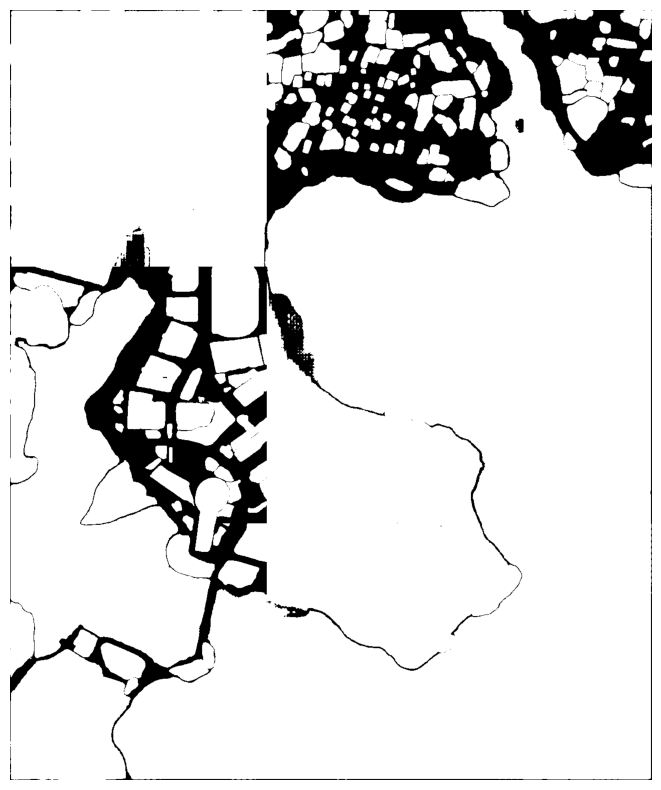

In [20]:
sam.show_masks(cmap="binary_r")

### 2.3 矢量化栅格数据

In [21]:
out_shp = os.path.join(shp_dir, "yangtzeu_wh.shp")

将 tiff 文件转换为矢量文件，`simplify_tolerance` 可以对输出矢量数据进行简化，值越大越简化。

In [22]:
sam.tiff_to_vector(out_mask, out_shp, simplify_tolerance=None)

## 3 可视化结果

In [23]:
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
Map.add_vector(out_shp, layer_name="Vector", style=style)
Map

Map(bottom=3446831.0, center=[30.533756439184707, 114.02469635009767], controls=(ZoomControl(options=['positio…